In [1]:
from keras import layers,models,optimizers
from keras.layers import Input,Conv2D,Dense, Reshape,Layer,Lambda
from keras.models import Model
from keras.utils import to_categorical
from keras import initializers
from keras.optimizers import Adam
from keras.datasets import mnist
import keras.backend as K

import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [0]:
def squash(output_vector, axis=-1):
    norm = tf.reduce_sum(tf.square(output_vector), axis, keep_dims=True)
    return output_vector * norm / ((1 + norm) * tf.sqrt(norm + 1.0e-10))


In [0]:
class MaskingLayer(Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self,inputs,**kwargs):
        # inputs is a list with [inputs_, mask]. Where inputs_ is output of digit Capsule layer with shape
        # [batch_size, num_classes, dim_vector] and mask is actual one hot encoded Y_train with shape
        # [batch_size, num_classes]. This function computes dot product of actual class one-hot vector with
        # [num_classes, dim_vector] shaped capsule outputs
        
        # So for each input we will be having num_classes output vectors each of size dim_vector. This function
        # will basically return the output vector pertaining to actual class. Thus output shape of this function
        # will be [batch_size, dim_vector]
        input_, mask = inputs
        masked_inputs = K.batch_dot(input_,mask, axes=1) # masked_inputs.shape = [batch_size, dim_vector]
        return masked_inputs
    
    def compute_output_shape(self,input_shape):
        *_,output_shape = input_shape[0]
        return (None,output_shape)

In [0]:
def PrimaryCapsule(inputs,dim_vector,n_channels,n_kernel_size,n_stride,padding="valid"):
    """
    Converts [batch_size,width,height,num_filters] shaped output of a regular Conv2D layer to output of
    Capsule Conv2D layer of shape [batch_size,width,height,n_channels*dim_vector] then reshapes this output
    to shape [batch_size, width*height*n_channels, dim_vectors] i.e. flattens the tensor keeping the dimension
    of capsule vector unchanged.
    """
    # conv_output.shape = [batch_size,width,height,n_channels*dim_vector]
    conv_output = Conv2D(filters = n_channels * dim_vector,
                  kernel_size = n_kernel_size,
                  strides = n_stride,
                  padding = padding,
                  name = "primary_capsule_conv2d_layer")(inputs)
    # Reshape conv_output by merging all dimensions except dim_vector dimension.
    # reshaped_output.shape = [batch_size, width*height*n_channels, dim_vector]
    reshaped_output = Reshape(target_shape = (-1,dim_vector),
                             name = "primary_capsule_reshape_layer")(conv_output)
    # Apply squash function to reshaped_output
    # reshaped_output.shape = [batch_size, widht*height*n_channels, dim_vector]
    squashed_output = Lambda(squash, name="primary_capsule_squash_layer")(reshaped_output)
    return squashed_output
    
    

In [0]:
class CapsuleLayer(Layer):
    """
    Takes vector outputs of Primary capsule layer at each neuron and each neuron computes an output vector.
    Input shape to each neuron of current layer is [batch_size, prev_layer_num_capsules, prev_layer_dim_vector]
    Output shape of single neuron of current layer is [batch_size,dim_vector]
    Output shape for all neurons of current layers is [batch_size, num_capsules, dim_vector]
    
    This is like as Dense layer. Only difference is that each neuron of Dense layer takes 
    [batch_size, prev_layer_num_neurons] shaped input and produces scalar output. While each capsule of
    CapsuleLayer takes [batch_size, prev_layer_num_capsules, prev_layer_dim_vector] shaped input and produces
    [batch_size, dim_vector] shaped output.
    """
    def __init__(self,n_capsule, dim_vector, n_routing, **kwargs):
        super(CapsuleLayer,self).__init__(**kwargs)
        self.n_capsule = n_capsule
        self.dim_vector = dim_vector
        self.n_routing = n_routing
        self.kernel_initializer = initializers.get("he_normal")
        self.bias_initializer = initializers.get("zeros")
        
    def build(self,input_shape):
        _ , self.input_n_capsule, self.input_dim_vector, *_ = input_shape
        # Initialize weights of this layer.
        self.W = self.add_weight(shape = [self.input_n_capsule, self.n_capsule, self.input_dim_vector, self.dim_vector],
                                initializer = self.kernel_initializer,
                                name = "W")
        # Initialize bias of this layer.
        # There is a bias associated with output of each input_n_capsule to each n_capsule. Thus
        # actual shape of bias is [input_n_capsule, n_capsule] however to make it similar to W
        # add dummy dimensions for batch_size (dim0), input_dim_vector (dim3) and dim_vector (dim4) 
        self.bias = self.add_weight(shape=[1, self.input_n_capsule, self.n_capsule, 1, 1], 
                                    initializer=self.bias_initializer, 
                                    name='bias', 
                                    trainable=False)
        self.built = True
        
    def call(self,inputs, training = None):
        # inputs.shape = [batch_size, input_num_capsule, input_dim_vector]
        # However dimensions of inputs should match with W (excluding batch_size) thus add dummy
        # dimensions for num_capsule and input_dim_vector.
        # Expand dims to [batch_size, input_num_capsule, 1, 1 ,input_dim_vector]
        input_expand = K.expand_dims(tf.expand_dims(inputs,axis=2),2)
        
        # Now same input_expand will be send to each capsule of current layer i.e. to n_capsule. So
        # replicate input_expand n_capsule times for n_capsule dimension (dim2).
        input_tiles = K.tile(input_expand, [1,1,self.n_capsule,1,1])
        
        """
        Compute dot product of W and input. Each vector of previous layer is routed to each neuron of current layer.
        Each prev layer vector 'u' is represented by last two dimensions i.e. [1, input_dim_vector]. This vector will
        be routed to each neuron of next layer and its dimensionality will be changed to [1, dim_vector]. For this
        we have a transformation matrix w_expand of shape [:,:,:, input_dim_vector, dim_vector]. For this specific
        vector consider this transformation sub-matrix to be of shape [input_dim_vector,dim_vector]. Now a single
        vector u.shape[1,input_dim_vector] is multiplied with transformation matrix 
        w.shape[input_dim_vector, dim_vector] to generate a new vector u_hat.shape[1,dim_vector]. Now this generated
        vector u_hat is routed to all neurons of current layer.
        """
        
        # Compute dot product of weight matrix with output vector of capsule of previous layer to generate
        # a prediction vector for each capsule of previous layer.
        
        # Same W is used for each datapoint of batch so replicate W batch_size times and add extra dim0 to W
        # to represent batch_size.
        # w_expand.shape = [batch_size, input_n_capsule, n_capsule, input_dim_vector, dim_vector]
        ### w_expand = K.expand_dims(self.W,axis=0)
        # Replicate w_expand batch_size times.
        ### w_tiles = K.tile(w_expand, [self.batch_size,1,1,1,1])
        # Now input and W have same shape, so do K.batch_dot of w_tiles and input_tiles along dim4 and dim3.
        # So do matrix multiplication of input_tiles * w_tiles using shapes 
        # [:,:,:, 1,input_dim_vector] * [:,:,:, input_dim_vector, dim_vector] = [:,:,:, 1, dim_vector]
        # This multiplication transforms each input_vector of dimension input_dim_vector to dimension dim_vector.
        # axes=[4,3] means do dot product on dim4 of input_tiles and dim3 of w_tiles.
        # inputs_hat.shape = [batch_size, input_n_capsule, n_capsule, 1, dim_vector] i.e. input vectors
        # u of dimensionality 'input_dim_vector' are transformed to output vectors u_hat of dimensionality
        # 'dim_vector'
        ### inputs_hat = K.batch_dot(input_tiles,w_tiles, axes=[4,3])
        
        """
        Above computation is just and explanation of what is happening in below line. For above computation
        we explicitly need batch_size that is not available (we have to explicitly pass it). So a better way
        is to share the weights across computations using below line of code.
        """
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]), 
                             elems=input_tiles, 
                             initializer=K.zeros( [self.input_n_capsule, self.n_capsule, 1, self.dim_vector]))
        
        
        """
        Now that we have u_hats (input_hats) we could proceed with routing algorithm.
        """
        for i in range(self.n_routing):
            # Each of output of prev layer will be weighted using a 'c' weight and forwarded for current layer
            # capsule. So 'c' weights are to be computed for each neuron of prev layer.
            # Initial values of 'c' will be same so initialize them with softmax(bias) as initial values of bias is
            # 0 matrix.
            # Each neuron of prev layer has number of biases of shape [n_capsule,1,1]
            c = tf.nn.softmax(self.bias, dim=2) # c.shape = [num_batches,input_n_capsule,n_capsule,1,1]
            
            # Now considering a single neuron of current layer, take output vectors from all neurons from prev
            # layer, multiply them with respective 'c' and add all weighted vectors together.
            weighted_sum_outputs = tf.reduce_sum(c * inputs_hat, axis=1,keep_dims=True)
            
            # Now squash weighted sum vector such that its norm is 1.
            # outputs.shape = [batch_size, 1, n_capsule, 1, dim_vector]
            outputs = squash(weighted_sum_outputs)
            
            # Keep on updating 'c' weights till second last iteration.
            if i != self.n_routing - 1:
                # compute similarity between  predicted and actual vector.
                similarity = inputs_hat * outputs
                self.bias += tf.reduce_sum(similarity,axis=-1, keep_dims=True)
                
            # Reshape output to shape [batch_size, n_capsule, dim_vector] i.e. for each input datapoint
            # each of n_capsule generates dim_vector dimensional output vector.
            reshaped_output = tf.reshape(outputs,[-1,self.n_capsule, self.dim_vector])
            
            return reshaped_output
        
    def compute_output_shape(self,input_shape):
        """
        Computes output shape for this layer.
        """
        return (None,self.n_capsule, self.dim_vector)
            

In [0]:
class LengthLayer(Layer):
    """
    Computes L2 length for each vector
    Output shape is [batch_size,1]
    """
    def call(self,inputs,**kwargs):
        # square each input value.
        squared_inputs = tf.square(inputs) 
        # Compute sum of squares for each vector and remove all reduced dimensions.
        sum_of_squares = tf.reduce_sum(squared_inputs, axis=-1, keep_dims=False)
        return tf.sqrt(sum_of_squares)
    
    def compute_output_shape(self, input_shape):
        *output_shape, _ = input_shape
        return tuple(output_shape)

In [0]:
def margin_loss(y_ground_truth, y_prediction):
    _m_plus = 0.9
    _m_minus = 0.1
    _lambda = 0.5
    L = y_ground_truth * tf.square(tf.maximum(0., _m_plus - y_prediction)) + _lambda * ( 1 - y_ground_truth) * tf.square(tf.maximum(0., y_prediction - _m_minus))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))


In [0]:
input_shape = [28, 28, 1]
n_class = 10
n_routing = 3


In [9]:
# Create training data.

(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
X_train = X_train.astype(np.float32)[:,:,:,None] / 255.0
X_test = X_test.astype(np.float32)[:,:,:,None] / 255.0

Y_train = to_categorical(Y_train.astype(np.float32),num_classes=n_class)
Y_test = to_categorical(Y_test.astype(np.float32),num_classes=n_class)

# Concatenate train and test data.
X = np.concatenate((X_train,X_test), axis=0)
Y = np.concatenate((Y_train,Y_test), axis=0)

print("X, Y:",X.shape, Y.shape)

11493376/11490434 [==============================] - 0s 0us/step
X, Y: (70000, 28, 28, 1) (70000, 10)


In [10]:
# Create encoder part of network. This part computes probability of each digit class.

x = Input(shape = input_shape)
# First normal convolution layer.
# conv1.shape = [batch_size,width,height,channels]
conv1 = Conv2D(filters=256, kernel_size=9, strides=1, padding="valid", activation="relu", name="conv1")(x)


# Take output of Conv2D layer and convert it to primary capsules.
# primary_capsule.shape = [batch_size,width,height,n_channels*dim_vector]
primary_capsule = PrimaryCapsule(inputs = conv1, dim_vector = 8, n_channels = 32,
                                n_kernel_size=9, n_stride=2)

# Now give primary_capsules as input to capsule layer which takes these vectors as input and performs routing
# and generates new vectors for next layer.
# digit_capsule.shape = [batch_size, n_capsule, dim_vector]
digit_capsule = CapsuleLayer(n_capsule = n_class, dim_vector = 16, n_routing = n_routing, name="digit_capsule")(primary_capsule)

# Now compute length of each output vector from previous layer. This will act as final class probability.
# output_capsule.shape = [batch_size, num_classes]
output_capsule = LengthLayer(name="output_capsule")(digit_capsule)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead


In [0]:
# Create decoder part. This is added after encoder part to regenerate image.

mask_input = Input(shape = (n_class,))

# mask.shape = [batch_size,dim_vector]
mask = MaskingLayer()([digit_capsule,mask_input]) # Get output vectors pertaining to actual class of digit.

# A group of dense layers.
dec = Dense(512, activation='relu')(mask)
dec = Dense(1024, activation='relu')(dec)
dec = Dense(784, activation='sigmoid')(dec)
dec = Reshape(input_shape)(dec)


In [14]:
# Create model.

model = Model([x,mask_input],[output_capsule,dec])
model.compile(optimizer="adam",loss=[margin_loss,"mae"],metrics=["accuracy"])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primary_capsule_conv2d_layer (C (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primary_capsule_reshape_layer ( (None, 1152, 8)      0           primary_capsule_conv2d_layer[0][0
__________________________________________________________________________________________________
primary_ca

In [15]:
# Train capsnet model.

# hist = model.fit([X, Y], [Y, X], batch_size=128, epochs=3, validation_split=0.2)
hist = model.fit([X, Y], [Y, X], batch_size=128, epochs=3, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 56000 samples, validate on 14000 samples
Epoch 1/3
56000/56000 [==============================] - 241s 4ms/step - loss: 0.2197 - output_capsule_loss: 0.0899 - reshape_1_loss: 0.1299 - output_capsule_acc: 0.9138 - reshape_1_acc: 0.8013 - val_loss: 0.1233 - val_output_capsule_loss: 0.0205 - val_reshape_1_loss: 0.1028 - val_output_capsule_acc: 0.9875 - val_reshape_1_acc: 0.8033
Epoch 2/3
56000/56000 [==============================] - 235s 4ms/step - loss: 0.1126 - output_capsule_loss: 0.0193 - reshape_1_loss: 0.0933 - output_capsule_acc: 0.9875 - reshape_1_acc: 0.8043 - val_loss: 0.0977 - val_output_capsule_loss: 0.0144 - val_reshape_1_loss: 0.0834 - val_output_capsule_acc: 0.9909 - val_reshape_1_acc: 0.8049
Epoch 3/3
56000/56000 [==============================] - 235s 4ms/step - loss: 0.0914 - output_capsule_loss: 0.0136 - reshape_1_loss: 0.0779 - output_capsule_acc: 0.9916 - reshape_1_acc: 0.8059 - val_loss: 0.0850 - val_output_ca

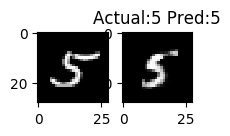

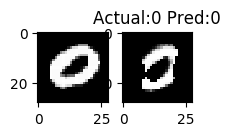

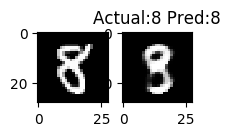

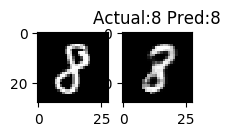

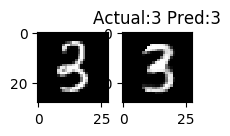

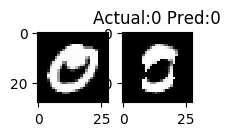

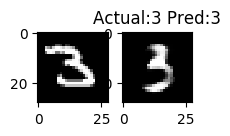

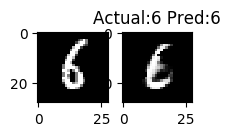

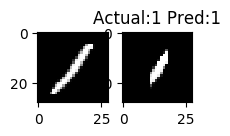

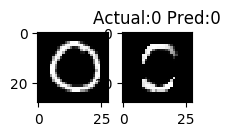

In [44]:
# Testing.

import matplotlib.pyplot as plt
plt.style.use('default')

num_test = 10
idx = np.random.permutation(np.arange(len(X)))
X_t = X[idx][:num_test]
Y_t = Y[idx][:num_test]

probs, regen_images = model.predict([X_t,Y_t])
max_index = np.argmax(probs,axis=1)
#print("probs:",probs)
#print("max_index:",max_index)
#print(probs[np.arange(len(probs)),max_index])
#print("probs, regen_images:", probs.shape, regen_images.shape)

for i in range(len(probs)):
  actual_img = X_t[i]
  pred_img = regen_images[i]
  actual_class = np.argmax(Y_t[i])
  pred_class = np.argmax(probs[i])
  
  #fig = plt.figure(figsize=(0.5,0.5))
  plt.subplots(nrows=1,ncols=2,figsize=(2,2))  
  plt.subplot(1,2,1)
  plt.imshow(actual_img[:,:,0],cmap="gray")
  
  plt.subplot(1,2,2)
  plt.imshow(pred_img[:,:,0],cmap="gray")
  plt.title("Actual:{} Pred:{}".format(actual_class, pred_class))
  plt.show()